In [2]:
def add(a, b):
    return a + b

def fancy_func(a, b, c, d):
    e = add(a,b)
    f = add(c, d)
    g = add(e, f)
    return g
print(fancy_func(1, 2, 3, 4))

10


In [3]:
import torch
from torch import nn
from d2l import torch as d2l

def get_net():
    net = nn.Sequential(nn.Linear(512, 256),
                        nn.ReLU(), 
                        nn.Linear(256, 128),
                        nn.ReLU(),
                        nn.Linear(128, 2))
    return net

x = torch.randn(size = (1, 512))
net = get_net()
net(x)

tensor([[ 0.0683, -0.0119]], grad_fn=<AddmmBackward0>)

In [4]:
net = torch.jit.script(net)
net(x)

tensor([[ 0.0683, -0.0119]], grad_fn=<AddmmBackward0>)

In [6]:
class Benchmark:
    def __init__(self, description='Done'):
        self.description = description
    def __enter__(self):
        self.timer = d2l.Timer()
        return self
    def __exit__(self, *args):
        print(f'{self.description}: {self.timer.stop():.4f}sec')
        
net = get_net()
with Benchmark('Without torchscript'):
    for i in range(1000): net(x)
    
net = torch.jit.script(net)
with Benchmark('With torchscript'):
    for i in range(1000): net(x)

Without torchscript: 1.1225sec
With torchscript: 0.8409sec


In [7]:
net.save('my_mlp')
!ls -lh my_mlp*

-rw-rw-r-- 1 shkim shkim 652K Jul 10 10:59 my_mlp


In [8]:
import os
import subprocess 
import numpy 
import torch 
from torch import nn
from d2l import torch as d2l

In [10]:
device = d2l.try_gpu()
a = torch.randn(size=(1000, 1000), device=device)
b = torch.mm(a, a)

with d2l.Benchmark('numpy'):
    for _ in range(10):
        a = numpy.random.normal(size=(1000,1000))
        b = numpy.dot(a, a)
with d2l.Benchmark('torch'):
    for _ in range(10):
        a = torch.randn(size=(1000,1000), device =device)
        b = torch.mm(a, a)

numpy: 0.8297 sec
torch: 0.0023 sec


In [12]:
with d2l.Benchmark():
    for _ in range(10):
        a = torch.randn(size=(1000,1000), device=device)
        b = torch.mm(a, a)
    torch.cuda.synchronize(device)

Done: 0.0046 sec


In [13]:
x = torch.ones((1, 2), device =device)
y = torch.ones((1, 2), device = device)
z = x*y+2
z

tensor([[3., 3.]], device='cuda:0')

In [14]:
import torch 
from d2l import torch as d2l

In [17]:
devices = d2l.try_all_gpus()
def run(x):
    return [x.mm(x) for _ in range(50)]

x_gpu1 = torch.rand(size=(4000,4000), device=devices[0])
x_gpu2 = torch.rand(size=(4000,4000), device=devices[1])

run(x_gpu1)
run(x_gpu2)
torch.cuda.synchronize(devices[0])
torch.cuda.synchronize(devices[1])

with d2l.Benchmark('GPU1 time'):
    run(x_gpu1)
    torch.cuda.synchronize(devices[0])
with d2l.Benchmark('GPU2 time'):
    run(x_gpu2)
    torch.cuda.synchronize(devices[1])

GPU1 time: 0.7083 sec
GPU2 time: 0.7098 sec


In [18]:
with d2l.Benchmark('GPU1 & GPU2'):
    run(x_gpu1)
    run(x_gpu2)
    torch.cuda.synchronize()

GPU1 & GPU2: 0.7431 sec


In [19]:
def copy_to_cpu(x, non_blocking=False):
    return [y.to('cpu', non_blocking=non_blocking) for y in x]

with d2l.Benchmark('Run on GPU1'):
    y = run(x_gpu1)
    torch.cuda.synchronize()
    
with d2l.Benchmark('Copy to CPU'):
    y_cpu = copy_to_cpu(y)
    torch.cuda.synchronize()

Run on GPU1: 0.7498 sec
Copy to CPU: 2.1422 sec


In [20]:
with d2l.Benchmark('Run on GPU1 and copy to CPU'):
    y = run(x_gpu1)
    y_cpu = copy_to_cpu(y, True)
    torch.cuda.synchronize()

Run on GPU1 and copy to CPU: 2.0868 sec


In [1]:
%matplotlib inline 
import torch 
from torch import nn 
from torch.nn import functional as F 
from d2l import torch as d2l

In [2]:
# Initialize model parameters

scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale 
b1 = torch.zeros(20) 
W2 = torch.randn(size=(50, 20, 5, 5)) * scale 
b2 = torch.zeros(50) 
W3 = torch.randn(size=(800, 128)) * scale 
b3 = torch.zeros(128) 
W4 = torch.randn(size=(128, 10)) * scale 
b4 = torch.zeros(10)

params = [W1, b1, W2, b2, W3, b3, W4, b4]

# Define the model 
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7] 
    return y_hat

# Cross-entropy loss function
loss = nn.CrossEntropyLoss(reduction='none')

In [3]:
def get_params(params, device):
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

new_params = get_params(params, d2l.try_gpu(0))
print('b1 weight:', new_params[1]) 
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


In [4]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)
    
data = [torch.ones((1, 2), device =d2l.try_gpu(i))*(i+1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


In [5]:
data = torch.arange(20).reshape(4, 5) 
devices = [torch.device('cuda:0'), torch.device('cuda:1')]

In [6]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices) 
print('input :', data) 
print('load into', devices) 
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


In [7]:
def split_batch(X, y, devices):
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

In [8]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)]
    for l in ls:
        l.backward()
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0])

In [9]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter, = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    #copy model parameters to num_gpus gpus
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim =[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            #perform multi-gpu training for a single minibatch
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        #evaluate the model on gpu0
        animator.add(epoch+1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch'
          f'on {str(devices)}')

test acc: 0.84, 2.4 sec/epochon [device(type='cuda', index=0)]


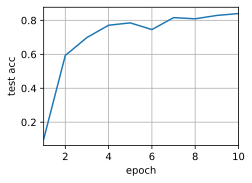

In [10]:
train(num_gpus=1, batch_size=256, lr=0.2)

test acc: 0.83, 2.7 sec/epochon [device(type='cuda', index=0), device(type='cuda', index=1)]


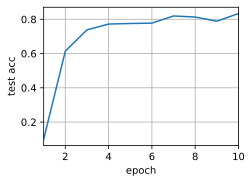

In [11]:
train(num_gpus=2, batch_size=256, lr=0.2)

In [13]:
import torch 
from torch import nn 
from d2l import torch as d2l

def resnet18(num_classes, in_channels=1):
    """A slightly modified ResNet-18 model."""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk=[]
        for i in range(num_residuals):
            if i==0 and not first_block:
                blk.append(d2l.Residual(out_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(out_channels))
        return nn.Sequential(*blk)
# this model uses a smaller convolution kernel, stride, padding and removes max-pooling layer
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True)) 
    net.add_module("resnet_block2", resnet_block(64, 128, 2)) 
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2)) 
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(), nn.Linear(512, num_classes)))
    
    return net

In [14]:
net = resnet18(10) 
# Get a list of GPUs
devices = d2l.try_all_gpus()
# We will initialize the network inside the training loop

/home/shkim/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [15]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(module):
        if type(module) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(module.weight, std=0.01)
    net.apply(init_weights)
    # set the model on multiple gpus
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch+1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch ' f'on {str(devices)}')

test acc: 0.90, 28.1 sec/epoch on [device(type='cuda', index=0)]


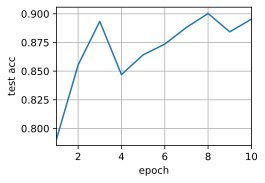

In [16]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

test acc: 0.85, 15.5 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


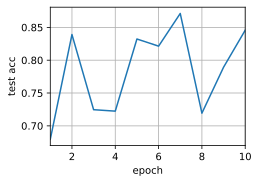

In [17]:
train(net, num_gpus=2, batch_size=512, lr=0.2)